# GreenBuildings 2: Imputing Missing Values With Scikit-Learn
------

__[1. Introduction](#first-bullet)__

__[2. Analyzing Distributions & Correlations](#second-bullet)__

__[3. Imputing Missing Values With Scikit-Learn ](#third-bullet)__

__[4. Next Steps](#fourth-bullet)__

## Introduction <a class="anchor" id="first-bullet"></a>
-------------
	
This is the second post in a series of blog posts about building a predictive model of green house gas emissions of buildings in NYC. In my [first post](http://michael-harmon.com/posts/greenbuildings1) I covered how to perform

- Exploratory data analysis
- Identify and remove outliers

In this current blog post I will cover the very important topic of 

- Imputing missing values

Specifically I will cover [imputations techniques](https://en.wikipedia.org/wiki/Imputation_(statistics)#Regression) using Scikit-Learn's [impute module](https://scikit-learn.org/stable/modules/impute.html) using both point estimates (i.e. mean, median) using the **[SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)** class as well as more complicated regression models (i.e. KNN) using the **[IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html)** class. The later requires that the features in the model are correlated.  This is indeed the case for our dataset and in our particular case we also need to [transform](https://en.wikipedia.org/wiki/Data_transformation_(statistics)) the feautres in order to discern a more meaningful and predictive relationship between them. As we will see, the transformation of the features also gives us much better results for imputing missing values.

I should remark that one must always first determine if missing values are missing at random or missing not at random. Values that are missing not at random are dangerous to impute. See [here](https://en.wikipedia.org/wiki/Missing_data#Missing_completely_at_random) for more discussion. In this case we don't really know why the data is missing and will impute the missing values.  Imputatation of missing values will introduces bias into our dataset, but as we saw in the last post that nearly 50% of the data had missing values, so we *have to do something*.

Lastly we remark that the use of KNN, while flexible and works quite well is not the best model imputing missing values for models in production. This is because KNN is a [memory-based model](http://www.cs.cornell.edu/courses/cs578/2007fa/CS578_knn_lecture.pdf) and stores the entire dataset which is impracticle for large datasets and models which require low latency. It was used in this case in-lieu of more traditional regression models because the features whose values we wished to impute did not follow a normal distribution.

## Analyzing Distributions & Correlations <a class="anchor" id="second-bullet"></a>
------------

We first import the necessary packages.  In the previous post I talked about using [Google Cloud Platform](https://cloud.google.com/) and won't go over the details of the configuations, but declare them in my list of import below:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings('ignore')

from google.oauth2 import service_account
from google.cloud import bigquery
import json
import pandas_gbq 

credentials = service_account.Credentials\
                             .from_service_account_file('./derby.json')

client = bigquery.Client(project     = credentials.project_id,
                         credentials = credentials)

pandas_gbq.context.credentials = credentials
pandas_gbq.context.project     = credentials.project_id

Let's first get the names of the columns (I actually forgot what they were):

In [2]:
result = client.query("""
SELECT 
    column_name
FROM 
    db_gb.INFORMATION_SCHEMA.COLUMNS
WHERE 
    table_name = 'no_outlier_data'
""")

for row in result.result():
    print(row[0])

Energy_Star
Site_EUI
NGI
EI
WI
GHGI
OPSFT
Age
Residential


Now that I know the names of the columns let's see exactly what the number of null values each column has and graph these counts.  To make it more interesting I break this down even further by incorporating whether the building was Multi-family or Office space:

Downloading: 100%|██████████| 2/2 [00:00<00:00,  5.44rows/s]


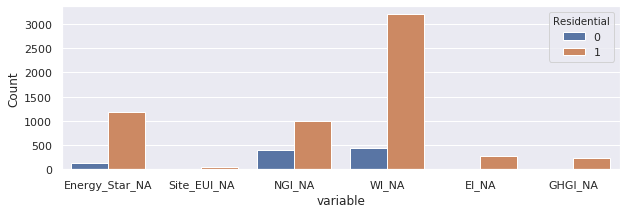

In [3]:
query = """
SELECT
   Residential,
   SUM(CASE WHEN Energy_Star IS NULL THEN 1 ELSE 0 END)  AS Energy_Star_NA,
   SUM(CASE WHEN Site_EUI IS NULL THEN 1 ELSE 0 END)  AS Site_EUI_NA,
   SUM(CASE WHEN NGI IS NULL THEN 1 ELSE 0 END)  AS NGI_NA,
   SUM(CASE WHEN WI IS NULL THEN 1 ELSE 0 END)  AS WI_NA,
   SUM(CASE WHEN EI IS NULL THEN 1 ELSE 0 END)  AS EI_NA,
   SUM(CASE WHEN GHGI IS NULL THEN 1 ELSE 0 END) AS GHGI_NA,
FROM 
    db_gb.raw_data 
GROUP BY
    Residential
"""

num_nulls_df  = pandas_gbq.read_gbq(query)

# reshape the dataframe 
num_nulls_df2 = num_nulls_df.melt(id_vars='Residential')\
                            .rename(columns={"value":"Count"})

# bar plot with break outs on residential column
plt.figure(figsize=(10,3))
sns.barplot(data=num_nulls_df2,
            x='variable',
            y='Count',
            hue='Residential')

We can see generally residential buildings have more missing values than office buildings.  This isn't quite a fair comparison as the number of residential buildings could be much larger than the number of office buildings and therefore inflating the number of missing values. 

What we are really interested in is *the percentage of missing values in each column and within each building type*:

Downloading: 100%|██████████| 2/2 [00:00<00:00,  5.71rows/s]


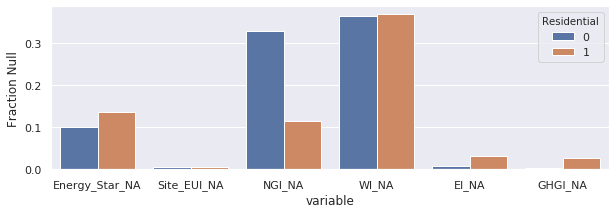

In [4]:
query = """
SELECT
   Residential,
   SUM(CASE WHEN Energy_Star IS NULL THEN 1 ELSE 0 END) / COUNT(*) AS Energy_Star_NA,
   SUM(CASE WHEN Site_EUI IS NULL THEN 1 ELSE 0 END) / COUNT(*) AS Site_EUI_NA,
   SUM(CASE WHEN NGI IS NULL THEN 1 ELSE 0 END) / COUNT(*) AS NGI_NA,
   SUM(CASE WHEN WI IS NULL THEN 1 ELSE 0 END) / COUNT(*) AS WI_NA,
   SUM(CASE WHEN EI IS NULL THEN 1 ELSE 0 END) / COUNT(*) AS EI_NA,
   SUM(CASE WHEN GHGI IS NULL THEN 1 ELSE 0 END) / COUNT(*) AS GHGI_NA,
FROM 
    db_gb.no_outlier_data 
GROUP BY 
    Residential
"""

frac_nulls_df = pandas_gbq.read_gbq(query)

# reshape the dataframe 
frac_nulls_df2 = frac_nulls_df.melt(id_vars='Residential')\
                              .rename(columns={"value":"Fraction Null"})
# bar plot with break outs on residential column
plt.figure(figsize=(10,3))
sns.barplot(data=frac_nulls_df2,
            x='variable',
            y='Fraction Null',
            hue='Residential')

This is a much more meaningful comparison!  Note that we are using the data *without any outliers*, that is the table resulting from the [last post](http://michael-harmon.com/blog/GreenBuildings1.html). We can see that,

- Water intensity (`WI`) is the field with highest percentage of missing values

- Natural Gas Intensity (`NGI`) has the second highest percentage of missing values. 

- `Energy_Star` also has a sizable amount of missing values.

**Site Energy Use Intensity (`EUI`), Electricity Intensity (`EI`) and Green House Gas Intensity (`GHGI`) have negligable amounts of missing values and those records with missing values will be dropped. Note that the sizable difference between Residential values means we have to take building type into account when imputing these values.** 

Let's pull all the columns to determine the relationship of each feature not only with `GHGI` (remember the final objective of these posts is to make a model that predicts `GHGI`), but also with all the other features.  We determine the relationships using a heat map of the correlation matrix as we did in the last post:

In [79]:
df = pandas_gbq.read_gbq("""
SELECT
   Energy_Star,
   Site_EUI,
   NGI,
   EI,
   WI,
   GHGI,
   Age,
   OPSFT,
   Residential,
FROM
    db_gb.no_outlier_data
""")

Downloading: 100%|██████████| 9834/9834 [00:01<00:00, 5066.82rows/s]


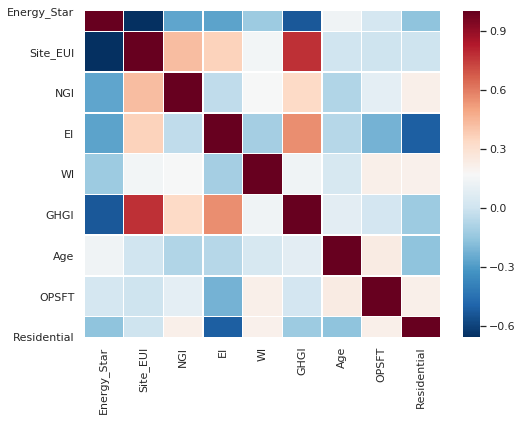

In [80]:
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
Xs      = scaler1.fit_transform(df)
xs_df   = pd.DataFrame(Xs, columns=df.columns)

fig, ax = plt.subplots(figsize=(8,6))  
sns.color_palette("BuGn_r",)
sns.heatmap(xs_df.corr(),
            linewidths=.5,
            cmap="RdBu_r")

We can see that,

- Occupancy Per Square Foot (`OPSFT`) and `Age` are not very correlated with `GHGI`.  Therefore we will not concern ourselves with them in our model.

- Water intensity (`WI`) is not very correlated and has as mentioned has A LOT missing values.

- `EI`, `NGI`, `Energy_Star`, and `GHGI`, are all highly correlated.

Let's look at the scatter plots of features and `GHGI`:

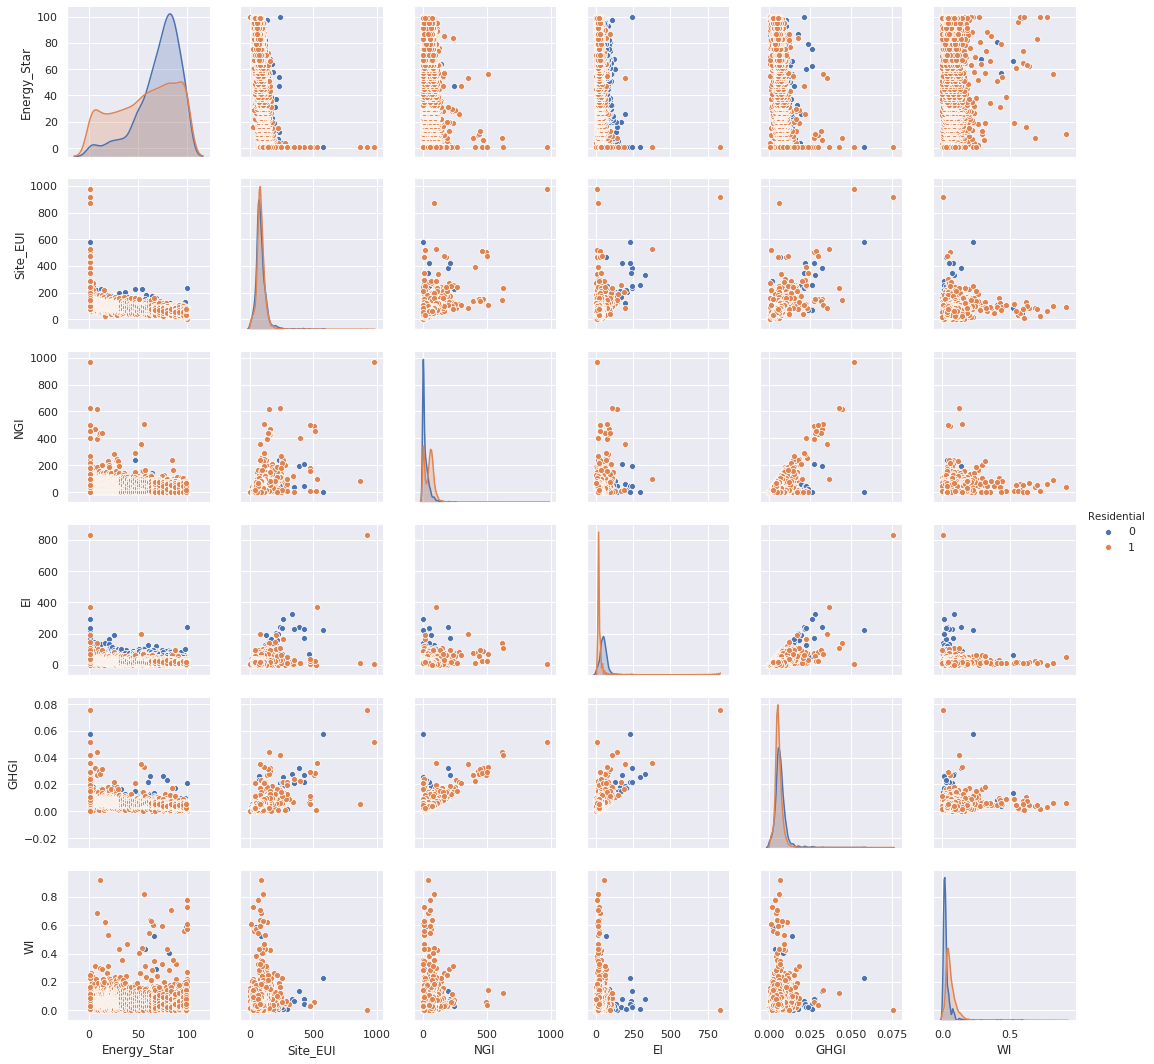

In [7]:
sns.pairplot(df,
             vars=["Energy_Star","Site_EUI","NGI","EI","GHGI", "WI"],
             hue='Residential')

In the above graph the off-diagonal grids are the relationship between the variables while the  graphs along the diagonal are the density of the variables. **We can see from the off-diagonal graphs there is [heteroscedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity) between the features and GHGI**, however, we won't address this issue too much in this post. The right most column shows that WI is not correlated with GHGI or any of the other features.  **We therefore will not be imputing missing values for water intensity (`WI`) and drop it as a feature for the model of GHGI** and instead be focusing on imputing missing values for 

1. **Energy_Star**
2. **NGI**

From the graphs along the diagonal all variables except for `Energy_Star` have sharply peaked [modes](https://en.wikipedia.org/wiki/Mode_(statistics)) with [long tails](https://en.wikipedia.org/wiki/Long_tail). Interestingly, `NGI` and `EI` seem to be bimodal distributions which will make things more difficult for imputing their missing values. In order to make the relations between features more visible I tried tranforming the data. The first transformation I used was too use the square root of all the variables except for `Energy_Star`.  The reason I chose I the squart root is because it will reduce the sharp-peakedness of the distributions and hopefully make them more normally distributed:

Downloading: 100%|██████████| 9834/9834 [00:01<00:00, 6043.71rows/s]


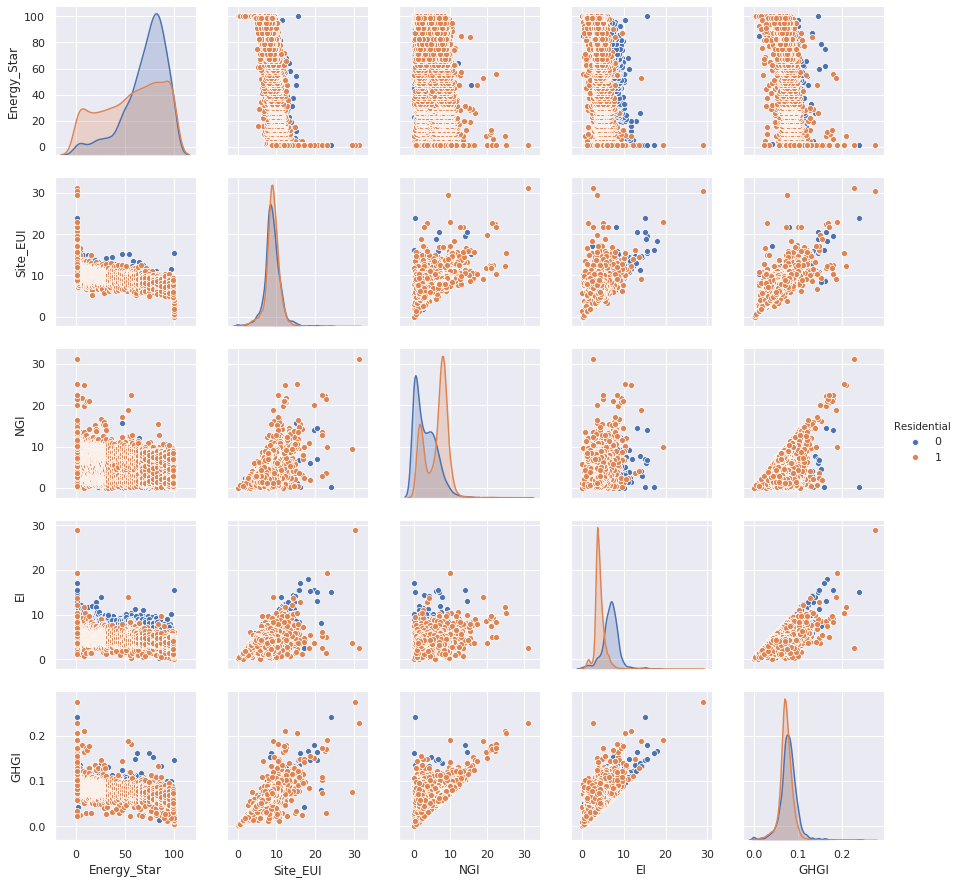

In [8]:
df_sqrt = pandas_gbq.read_gbq("""
SELECT
   Energy_Star,
   SQRT(Site_EUI) AS Site_EUI,
   SQRT(NGI)      AS NGI,
   SQRT(EI)       AS EI,
   SQRT(GHGI)     AS GHGI,
   Residential,
FROM 
    db_gb.no_outlier_data
""")

sns.pairplot(df_sqrt,
             vars=["Energy_Star","Site_EUI","NGI","EI","GHGI"],
             hue='Residential')

**We can see that neither `Energy_Star` nor `NGI` are normally distributed, meaning that a linear regression model would not be appropriate in this situation and hence choose a more flexible regression model.** Interesting the relationship between `Energy_Star` and `Site_EUI` seams to be somewhat [sigmodal](https://en.wikipedia.org/wiki/Sigmoid_function) in shape signfiying a non-linear relationship between the two. 

The relationship between `NGI`, `Site_EUI` and `GHGI` seems to be linear, but suffering from [heteroscedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity). One way to reduce the variance is to use use log tranformations on the variable. For the purposes of imputing missing values in `NGI` we only really care heteroscedasticity in the `NGI` and therefore only transform it. Inorder to avoid the issue of introducing infinities when `NGI` is zero into we add a 1 when log transforming it:

In [9]:
df_sqrt["LOG_NGI"] = np.log(1 + df_sqrt["NGI"])

Now lets look at the relationship of this variable with respect to the square root of the other features:

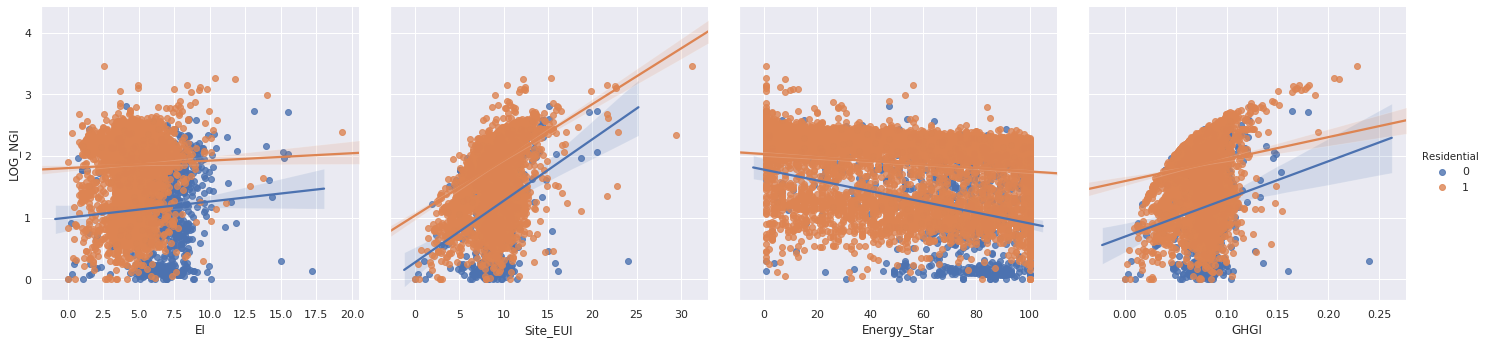

In [10]:
sns.pairplot(df_sqrt, 
             x_vars=['EI','Site_EUI','Energy_Star','GHGI'], 
             y_vars='LOG_NGI', 
             hue='Residential',
             kind = 'reg',
             size=5, 
             dropna=True)

We can see that that the heteroscedasticity between `LOG_NGI` and `Site_EUI` has been reduced.  Let's look at what these transformation does to `NGI`'s distribution:

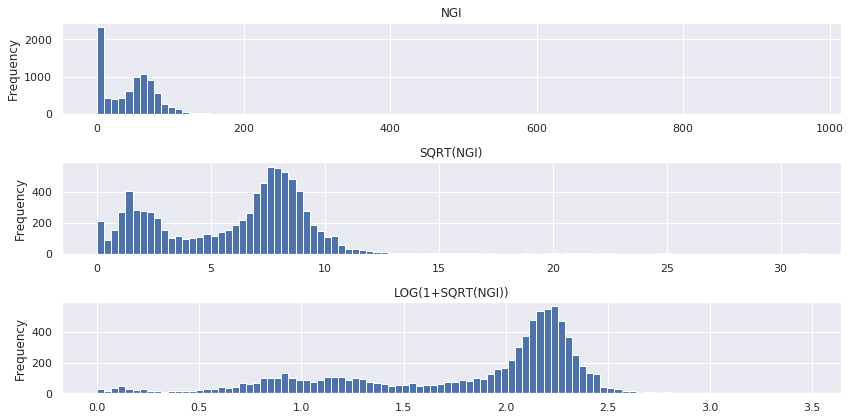

In [11]:
plt.figure(figsize=(12,6))
plt.subplot(311)
df["NGI"].plot(kind="hist",bins=100,title="NGI")

plt.subplot(312)
df_sqrt["NGI"].plot(kind="hist",bins=100,title="SQRT(NGI)")

plt.subplot(313)
df_sqrt["LOG_NGI"].plot(kind="hist",bins=100,title="LOG(1+SQRT(NGI))")

plt.tight_layout()

We can see that the square root transformation spreads out values of `NGI` and there are clearly two modes in the distribution (this results from the two building types). The log transformation spreads out the values of `NGI` even further reducing the bimodality, but keeping a fat tail in the distribution. It's hard for me to say which transformed verisons of `NGI` are better best. Ultimately we will choose whichever transformation gives us the best performance in predicting `GHGI`.

## Imputing Missing Values With Scikit-Learn <a class="anchor" id="third-bullet"></a>
--------------------

Now let's move onto the process of imputing missing values for `Energy_Star` and `NGI` using Scikit-learn's [impute module](https://scikit-learn.org/stable/modules/impute.html).  Ultimately we are interested in predicting `GHGI` and therefore set up the imputation of the missing values as stage in a simple linear regression model for `GHGI`.  We will then choose the imputation technique that gives the best $R^{2}$ value for the model.  **We perform the imputation in this method as using the target variable (`GHGI`) to directly impute missing values of features would introduce extra bias into our model that we wish to avoid.** Let's read in the transformed dataset removing the cases where the `GHGI`, `Site_EUI` and `EI` are not null:

In [19]:
df2 = pandas_gbq.read_gbq("""
SELECT
   Energy_Star AS     Energy_Star,
   SQRT(Site_EUI)     AS SQRT_EUI,
   SQRT(NGI)          AS SQRT_NGI,
   LOG(1 + SQRT(NGI)) AS LOG_NGI,
   SQRT(EI)           AS SQRT_EI,
   SQRT(GHGI)         AS SQRT_GHGI,
   Residential,
FROM 
    db_gb.no_outlier_data
WHERE 
    GHGI IS NOT NULL
AND EI IS NOT NULL
AND Site_EUI IS NOT NULL

""")

print("Number of datapoints: ", df2.shape[0])

Downloading: 100%|██████████| 9542/9542 [00:01<00:00, 5552.54rows/s]

Number of datapoints:  9542


Next lets import the necessary packages and create our training set and test set:

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.pipeline     import make_pipeline, Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute       import SimpleImputer, IterativeImputer
from sklearn.neighbors    import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
import numpy as np

X_real = df2.drop(['SQRT_GHGI'], axis=1)
Y_real = df2['SQRT_GHGI']

X_train, X_test, Y_train, Y_test = train_test_split(X_real,Y_real, random_state=32)

Let's first use just the square root of `NGI` and then see what value using the log tranformation adds with dealing with the heteroscedasticity in the data:

In [44]:
# using the SQRT(NGI)
X_train1 = X_train.drop("LOG_NGI", axis=1)
X_test1  = X_test.drop("LOG_NGI", axis=1)

# using the LOG(1 + SQRT(NGI))
X_train2 = X_train.drop("SQRT_NGI", axis=1)
X_test2  = X_test.drop("SQRT_NGI", axis=1)

Let's first look at the using the mean of the feature values to fill in for the missing values using the [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) class.

In [45]:
mean_pipe = make_pipeline(SimpleImputer(strategy='mean'),
                          StandardScaler(),
                          LinearRegression())

print("Cross Validated R^2:", np.mean(cross_val_score(mean_pipe, X_train1, Y_train, cv=5)))

mean_pipe.fit(X_train1, Y_train)
Y_pred = mean_pipe.predict(X_test1)

# Explained variance score: 
print("Test R^2: {}".format(r2_score(Y_test, Y_pred)))

Cross Validated R^2: 0.7728948575377176
Test R^2: 0.7353835183095065


Using the mean value of each feature to fill in for the missing value overall does quite well.  The high $R^{2}$ is due to the highly fact the `Site_EUI` and `GHGI` are highly correlated. Often times people use the median instead of the mean when imputing missing values. This is especially true when there are outliers in the data as the mean is more sensitive to outliers than the median.  Let's see how using the median performs:

In [46]:
median_pipe = make_pipeline(SimpleImputer(strategy='median'),
                            StandardScaler(),
                            LinearRegression())

print("Cross Validated R^2:", np.mean(cross_val_score(median_pipe, X_train1, Y_train, cv=5)))

median_pipe.fit(X_train1, Y_train)
Y_pred = median_pipe.predict(X_test1)

# Explained variance score: 

print("Test R^2: {}".format(r2_score(Y_test, Y_pred)))

Cross Validated R^2: 0.7713591852735993
Test R^2: 0.7343757833703362


Not much of a difference, but we can see using the median instead of the mean in this case is slightly worse!  

Now, let's try using the correlation between features to impute the missing values. **Since the relationship between `Energy_Star` and the rest of the features is non-linear we use a [K Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) regession method as this model can does not assume linearity between the features.**  Instead KNN regression methods averages the values of the K nearest neighbors to impute the missing values.  In order to determine the best values of K to use we will create a grid search and use cross-validation to control for overfitting.  We create the Scikit-learn pipeline:

In [47]:
knn_pipe = Pipeline([("scaler",  StandardScaler()),
                     ("imputer", IterativeImputer(estimator=KNeighborsRegressor())),
                     ("reg",     LinearRegression())])

Next we create a dictionary containing the parameters we want to search over:

In [57]:
params = {"imputer__estimator__n_neighbors": [1,5,10,15,20],
          "imputer__estimator__weights":     ["uniform","distance"]}

Note that we have to use a `imputer__estimator__` instead of the traditional `imputer__` to assign the hyper-parameter values within the pipeline. Then we define the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) object and set $R^2$ as the scoring metric.

In [35]:
grid   = GridSearchCV(estimator   = knn_pipe,
                      param_grid  = params,
                      scoring     = "r2",
                      cv          = 5,
                      n_jobs      =-1)

Let's perform the grid search and find performance of the best model:

In [58]:
grid.fit(X_train1, Y_train)

# get the best estimator
knn_imputer = grid.best_estimator_
print("Cross Validated R^2: ", grid.best_score_)

Cross Validated R^2:  0.77417344326708


In [59]:
Y_pred = knn_imputer.predict(X_test1)

# Explained variance score: 
print("Test R^2: {}".format(r2_score(Y_test, Y_pred)))

Test R^2: 0.7368308332916311


The results are slightly better than using the mean for imputing missing values.  Instead of imputing the missing values for `SQRT(NGI)`, let's instead impute the missing values for `LOG(1 + SQRT(NGI)` and see if this improves the model. I'm thinking it will since reducing the heteroscedasticity in that feature may bring points closer together:

In [60]:
grid.fit(X_train2, Y_train)
knn_imputer2 = grid.best_estimator_

Y_pred = knn_imputer2.predict(X_test2)

# Explained variance score: 
print("Test R^2: {}".format(r2_score(Y_test, Y_pred)))

Test R^2: 0.7437197904635404


It worked! The KNN model works better using the log of the square root instead of just the square root. **Note that the $R^2$ can be a bad metric for feature selection as increasing the number of features increases the $R^2$, however, it is appropriate in this case as we are just swapping one feature for another.**

Let's see the imputer that worked the best by taking apart the pipeline:

In [78]:
scaler  = knn_imputer2[0]
imputer = knn_imputer2[1]
print(imputer)

IterativeImputer(add_indicator=False,
                 estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                               metric='minkowski',
                                               metric_params=None, n_jobs=None,
                                               n_neighbors=5, p=2,
                                               weights='uniform'),
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, max_value=None, min_value=None,
                 missing_values=nan, n_nearest_features=None, random_state=None,
                 sample_posterior=False, skip_complete=False, tol=0.001,
                 verbose=0)


We can see that the optimal number of neighbors is 5.  

Now let's impute the missing values. We have to first scale the featuers, impute the missing values and finally unscale the features:

In [64]:
X_fixed = scaler.inverse_transform(
                imputer.transform(
                    scaler.transform(X_real.drop("SQRT_NGI", axis=1))))

# add the columns names
X_df = pd.DataFrame(X_fixed, columns=X_real.drop("SQRT_NGI", axis=1).columns)

Note that we droped the `SQRT(NGI)` feature since we won't be imputing those values. We then create the same `GHGI` concatenating the previous dataframe with the `GHGI` series:

In [65]:
X_sqrt_df = pd.concat([X_df.reset_index().drop("index",axis=1), 
                       Y_real.to_frame().reset_index().drop("index",axis=1)], 
                     axis=1)

Before we finish off we have to inverse-tranform the features and rename the columns:

In [75]:
# inverse transform the features
X_sqrt_df["NGI"] = np.exp(X_sqrt_df["LOG_NGI"])-1

X_fin_df   = X_sqrt_df.apply(lambda x: x*x)

# rename 
X_fin_df.drop("LOG_NGI", inplace=True, axis=1)

X_fin_df   = X_fin_df.rename(columns={"SQRT_EI"  : "EI",
                                       "SQRT_EUI" : "Site_EUI",
                                       "SQRT_GHGI": "GHGI"})

Let's look at the resulting features values one last time.

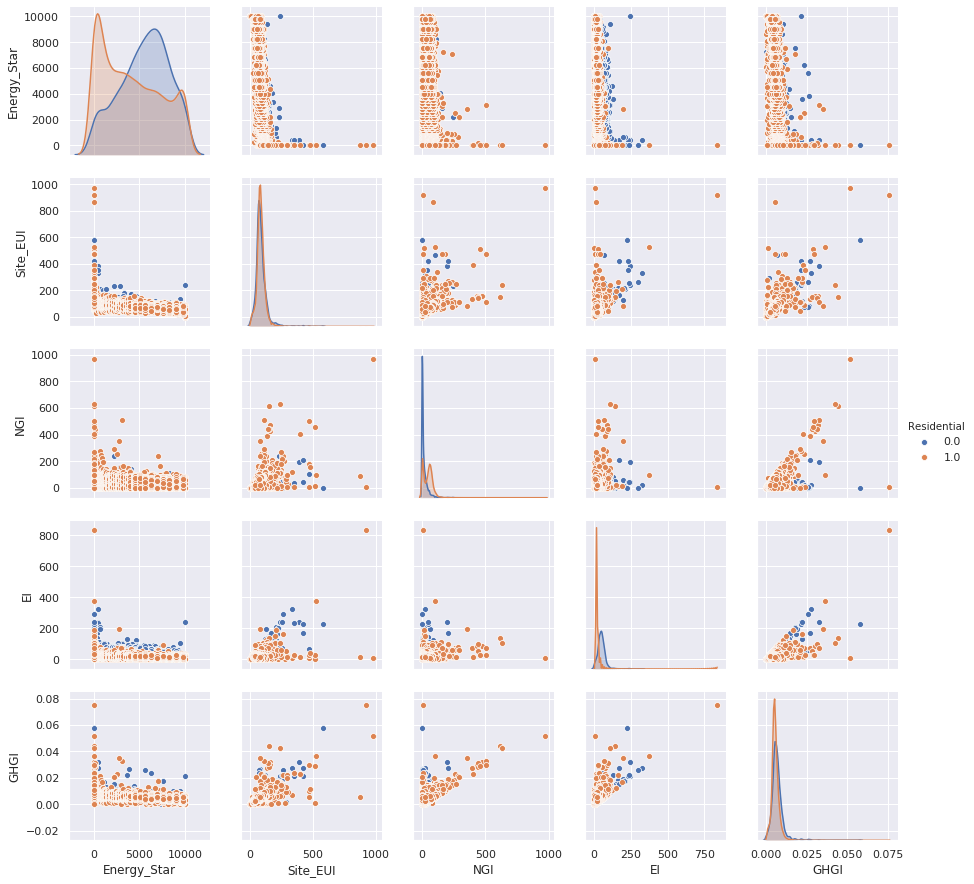

In [76]:
sns.pairplot(X_fin_df,
             vars=["Energy_Star","Site_EUI","NGI","EI","GHGI"],
             hue='Residential')

Note that the distribution of `Energy_Star` looks very different than when we initially started! The bias introduced by imputing the missing values skewed it to low values.  

Finally let's write the results back to BigQuery:

In [77]:
pandas_gbq.to_gbq(X_fin_df,"db_gb.clean_data")

1it [00:04,  4.95s/it]



## Next Steps  <a class="anchor" id="fourth-bullet"></a>
---------------

In this post we covered techniques for imputing the missing values using Scikit-learn's [impute module](https://scikit-learn.org/stable/modules/impute.html). In the [previous post](http://michael-harmon.com/blog/GreenBuildings1.html) we covered the topics of exploratory analysis and removing outliers. These three topics are the bedrock of wrangling and cleaning data and form a solid basis for any modeling effort. In the next post we will build off this work and move toward advanced regression methods for predicting the green house gas emission intensity of buildings from this dataset.